# 272B Homework 4 Template
---
## PART 1
---

## Imports, Constants, and Dataset loading

In [35]:
# TensorFlow Imports
from tensorflow.keras import layers, models, losses, callbacks, utils, preprocessing, regularizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.math import confusion_matrix
from tensorflow.data import Dataset
from tensorflow.strings import lower, regex_replace
import tensorflow as tf
import os
import matplotlib.pyplot as plt

### Parameters and Helper Functions

In [36]:
# TODO: Set parameters you want for part 1 (or hard code later, this might be easier)
# You could also add any generic helper functions you want

random_seed = 42
tf.random.set_seed(random_seed)

# For data
validation_split = 0.25
batch_size = 32
epochs = 10
label_mode = 'int' # check https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory

# For TextVectorization
vocab_size = 10000
max_text_length = 250

### Problem (1) Load the dataset and explain the path structure of the loaded data
a) Download the Stack Overflow dataset to a directory of your choice (Code) and 
>
b) Inspect the folder content. "Inspect" means go the left-hand side and open the file browser of the Collab environment until you can find the data. What is the path structure (as in, what subfolders exist in the directory you made)? 

/content/hw4/

.....................models/

.......................test/

......................train/

...................README.md

...stack_overflow_16k.tar.gz


In [37]:
data_url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
data_dir = '/content/hw4'
data_cache = utils.get_file(
    'stack_overflow_16k.tar.gz',
    data_url,
    untar = True,
    cache_dir = '',
    cache_subdir = data_dir # specify download directory
)

### Problem (2) Split into train, test, validation
a) Explain how `preprocessing.text_dataset_from_directory` finds labels for the samples.
> Calling this function will return batches of texts from the subdirectories under the main directory. In this case the main directory will be `/content/hw4/test` and the subdirectories will be `csharp`, `java`, `javascript`, and `python`.

b) What is the options and purpose of the input variable `label_mode`?

*   `int`: labels are encoded as integers
*   `categorical`: labels are encoded as an categorical vector
*   `binary`: labels are encoded as `float32` scalars with values of 0 or 1
*   None: no labels

> The different types of labels are meant for calculations of different loss functions (e.g., `sparse_categorical_crossentropy`, `categorical_crossentropy`, `binary_crossentropy`, etc.)






c) Perform the split. (Code)

In [38]:
# TODO : Add necessary arguments to complete the train-validation-test split

# By putting arguments in here, we can share them across calls using **kwargs ('keyword arguments')
# We know batch_size, label mode, and random seed (for reproducability) will be consistant
dataset_args = dict(
    seed= random_seed,
    batch_size= batch_size,
    label_mode= label_mode,
)

data_train = preprocessing.text_dataset_from_directory(
    directory = data_dir + '/train',
    validation_split = validation_split,
    subset = 'training', 
    **dataset_args
)

data_validation = preprocessing.text_dataset_from_directory(
    directory = data_dir + '/train',
    validation_split = validation_split,
    subset = 'validation', 
    **dataset_args
)

data_test = preprocessing.text_dataset_from_directory(
    directory = data_dir + '/test', 
    **dataset_args
)

print(f"Number of batches in data_train: {data_train.cardinality()}")
print(f"Number of batches in data_validation: {data_validation.cardinality()}")
print(f"Number of batches in data_test: {data_test.cardinality()}")

Found 8000 files belonging to 4 classes.
Using 6000 files for training.
Found 8000 files belonging to 4 classes.
Using 2000 files for validation.
Found 8000 files belonging to 4 classes.
Number of batches in data_train: 188
Number of batches in data_validation: 63
Number of batches in data_test: 250


## Main assignment

### Problem (3) Text standardization
(a) Write a standardization function so that all text input to the model is consistent. The standardization is up to you, but a common starting point is to lowercase all words. (Code)

(b) EXPLAIN your chosen standardization. Why do you think your choices will help for a dataset from StackOverflow?
> I tried the default setting: `'lower_and_strip_punctuation'` for the argument `standardize` of the function `tf.keras.layers.TextVectorization`. What the argument does is to lowercase all the letters and remove all the punctuations in the string. Since I don't exactly know what kind of formats is the data provided with, it will be optimal to start with the fundamentals instead of filtering out too much key information.

(c) Train your TextVectorization layer on the training dataset with a max vocabulary size of 10,000 and output sequence length of 250. Make sure to use your standardization function! (Code)

(d) Describe the preprocessing step of the raw sentence data and the label. How did you decide how to standardize the text? (Hint: how does TextVectorization work?)
> First, we simplify the provided text data (e.g., remove puntuations, remove HTML elements, convert all letters to lowercase, etc.). Then, we tokenize the simplified texts, which is splitting the strings into individual words. Lastly, we convert the tokens into numbers, which will result in a vector that can be fed into theneurla network model for training.

In [39]:
# Standardization for strings input to model
import string
import re

# TODO write your standardization function
# tf.strings module will be helpful
# regex (re) module will be helpful
def custom_standardization(inputs):
    lowercase = lower(inputs)
    stripped_html = regex_replace(lowercase, '<br />', ' ')

    return regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

# Build the vectorization layer. It takes the parameters you set at the top
encoder = TextVectorization(
    max_tokens = vocab_size, # Maximum size of the vocabulary for this layer
    output_sequence_length = max_text_length, # The output will have its time dimension padded or truncated to exactly output_sequence_length values
    standardize = 'lower_and_strip_punctuation', # Text will be lowercased and all punctuation removed
)

# TODO train your TextVectorization layer by 
# a) making a text only dataset (from train)
# b) using adapt()
data_train_text_only = data_train.map(lambda x, y: x)
encoder.adapt(data_train_text_only) # fit the state of the preprocessing layer to the dataset (only use your training data when calling adapt, using the test set would leak information)

### Problem (4) Visualize

Print:

a)  Show one sentence example from the training dataset (Code). Are you able to tell which tag (python, java, javascript, csharp) this question belongs to?
> It belongs to javascript.

b) What is the vector encoding for the sentence example you've printed above? (Code)

c) The top 10 most common 'tokens' in your dataset (Code)

d) The bottom 10 most common 'tokens' in your dataset (Code)

e) Do the top 10 and bottom 10 words make sense for our dataset? Explain.
> They don't make sense at all. Since the standardization method I've adopted is `lower_and_strip_punctuation`, there still exists meaningless pronouns which do not contribute much to classifying the tags.


In [40]:
# A PrettyPrinter() might help printing large vectors
import pprint
import random
import numpy as np

pp = pprint.PrettyPrinter()

# TODO: extract one question/label pair from the dataset, and display
for text_batch, label_batch in data_train.take(1):
    text = text_batch.numpy()[0]
    label = label_batch.numpy()[0]

print("QUESTION: ")
pp.pprint(text)

print("\nLABEL: ")
pp.pprint(label)

# TODO Vectorize the question from above, and display
print("\nQUESTION VECTOR: ")
pp.pprint(encoder(text))

# TODO Print the top 10 and bottom 10 vocabulary words
vocab = np.array(encoder.get_vocabulary())
most_common = vocab[:10]
least_common = vocab[-10:]

print('\nTOP 10 VOCAB WORDS: ')
pp.pprint(most_common)

print('\nBOTTOM 10 VOCAB WORDS: ')
pp.pprint(least_common)


QUESTION: 
(b'"blank code not working when displaying value of html element i want to disp'
 b'lay details in div element(id=""displaystoragevol2""). why below code is not'
 b' working..&lt;hr&gt;.&lt;h3&gt;localstorage app vol-2&lt;/h3&gt;.&lt;label&g'
 b't;first name: &lt;/label&gt;&lt;input type=""text"" id=""firstnamevol2""&gt;'
 b'.&lt;label&gt;last name: &lt;/label&gt;&lt;input type=""text"" id=""lastname'
 b'vol2""&gt;.&lt;button type=""submit"" id=""fetchdetailsvol2""&gt;submit&lt;/'
 b'button&gt;.&lt;div id=""displaystoragevol2""&gt;&lt;/div&gt;.&lt;hr&gt;..   '
 b" &lt;script&gt;.    /*localstorage vol 2*/.    document.getelementbyid('fetc"
 b"hdetailsvol2').addeventlistener('click', fetchfunction);.    var firstnamevo"
 b"l2 = document.getelementbyid('firstnamevol2').value;.    var lastnamevol2 = "
 b"document.getelementbyid('lastnamevol2').value;.    var displaystoragevol2 = "
 b"document.getelementbyid('displaystoragevol2');...    function fetchfunction("
 b'){            


### Problem (5) Understanding the LSTM model.

a) What's the Keras Embedding Layer for?
> The embedding layer plays the role of mapping integer indices (represents specific vocabularies) to dense vectors (embeddings of the integer indices).

b) What do `masking` and `padding` mean in this context?


*   `masking`: a way to tell sequence-processing layers that certain timesteps in an input are missing and thus should be skipped when processing the data.
*   `padding`: a special form of `masking` where the masked steps are at the beginning or the end of a sequence. In order to fit all sequences into the given standard length, padding or truncating some sequences is necessary.



c) Describe in your own words why LSTM is called long short-term memories.
> LSTM is capable of "remembering" **short-term** data over a **long** period of time. It is a particular type of RNN with the mechanism to avoid the vanishing gradient problem.

d) What is the difference between Conv1D and LSTM?


*   Conv1D: performs 1D convolution over a vector of data. It is mainly used in CNNs.
*   LSTM: a neuron unit that feeds information back to itself for the next time step in sequence. It is mainly used in RNNs.



e) Create a lone embedding layer and inspect it by feeding it a random input from the (vectorized) dataset. What is the input shape? What is the output shape? (Code)
> Input shape: (1, 250, 32), output shape: (1, 16)

f) Create a lone Keras LSTM layer and inspect it by feeding it the random output of the embedding layer above.  (Code)
> i) What shape of the input does it require? What is the output shape? (Code)

> ii) Set `return_sequence` and `return_state` to be True. What is the output shape now? (Code)

> iii) Explain the difference between `return_sequence` and `return_states`.


*   `return_sequence`: returns all the hidden state values (full sequence) from each timestep
*   `return_state`: returns the last cell state ($c^t$) of the RNN in addition its hidden states



In [41]:
# TODO make a lone embedding layer: embed a `vocab_size` word vocabulary in `output_dim` dimensions
embedding_sample = layers.Embedding(
    input_dim = len(encoder.get_vocabulary()) + 1, # Size of the vocabulary, i.e. maximum integer index + 1
    output_dim = 32, # Dimension of the dense embedding
    mask_zero = True, # whether or not the input value 0 is a special "padding" value that should be masked out
    input_length = max_text_length,
)

# TODO make lone LSTM layers 
units = 16 # dimensionality of the output space
LSTM_sample = layers.LSTM(units)
LSTM_sample_sequences = layers.LSTM(units, return_sequences=True)
LSTM_sample_state = layers.LSTM(units, return_state=True)
LSTM_sample_both = layers.LSTM(units, return_state=True, return_sequences=True)

for text_batch, label_batch in data_train.take(1):
    # TODO send a random data sample through the embedding layer
    text = tf.expand_dims(text_batch[0], 0)
    embedded = embedding_sample(encoder(text))
    print("Embedded: {}".format(embedded.shape))
    # TODO Send the embedded sample through the various LSTM layers and answer the questions above
    output1 = LSTM_sample(embedded)
    print("LSTM_sample: {}".format(output1.shape))
    output2 = LSTM_sample_sequences(embedded)
    print("LSTM_sample_sequences: {}".format(output2.shape))
    output3 = LSTM_sample_state(embedded)
    print("LSTM_sample_state: {}".format(len(output3)))
    output4 = LSTM_sample_both(embedded)
    print("LSTM_sample_both: {}".format(len(output4)))

Embedded: (1, 250, 32)
LSTM_sample: (1, 16)
LSTM_sample_sequences: (1, 250, 16)
LSTM_sample_state: 3
LSTM_sample_both: 3


### Problem (6) Building an LSTM model

a) Write a function that can construct an LSTM model, starting with an Embedding layer. The variable inputs should include num_lstm_layers, num_dense_layers. Other things you might include are dropout layers or regularizers for LSTM/Dense. Remember to end with a softmax dense layer with 4 neurons for the language classes. USE CHECKPOINTS TO SAVE MODELS BETWEEN EPOCHS (Code)

b) Write a function to train your model(s). (Code)

c) Start with the basic model with one LSTM layer. Plot the training and validation accuracy versus epochs, and training and validation loss versus epochs. What do you observe? (Code + Text)
> The validation accuracy increases in the first few epochs, and then does not have any significant improvement afterwards. The validation loss, on the other hand, increases steadily throughout the epochs. This phenomenon suggests that overfitting has occured since the early stages of training.

The prediction for problem 7 is incorrect as well.

d) Add several more LSTM layers to your model. How does it affect the training accuracy? Compare to the single layer results. (Code + Text)
>I applied 2 layers of LSTM since it is sufficient to detect more complex features according to this [blog](https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046#:~:text=Generally%2C%202%20layers%20have%20shown,to%20find%20reasonably%20complex%20features.). The results are pretty similar though. The only explicit differences are that the accuracies and losses have less variations and the figures are slightly better (higher accuracy, lower loss) than those of the basic model with one LSTM layer.

e) Evaluate both models on the test data, and print your metrics. Include a confusion matrix. Which languages are the most difficult to differentiate? (Code)


In [42]:
# TODO Write a function that builds a full LSTM network.
def my_LSTM(vocab_length = vocab_size, name = None):
    model = tf.keras.Sequential(name=name)
    model.add(
        layers.Embedding(
            input_dim = vocab_length,
            output_dim = 64,
            mask_zero = True,
            input_length = 250,
            name='embedding'
        )
    )
    
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(32)))

    model.add(layers.Dense(32))
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax')) # 4 classes

    return model

# Fitting function
def fit(model, encoded_data_train, encoded_data_val, epochs=epochs):
    
    # TODO complete checkpoint to save best model
    checkpoint_file = '/content/hw4/models/saved_model_{}.h5'.format(epochs)
    checkpoint = callbacks.ModelCheckpoint(
        checkpoint_file,
        monitor='val_loss',
        save_best_only=True,
        mode='min', # lowest loss, highest accuracy
        save_format='tf'
    )
    #early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=2)

    # TODO: Compile mode with Sparse Categorical Crossentropy
    model.compile(
        loss= losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer= tf.keras.optimizers.Adam(),
        metrics= ['accuracy']
    )
    
    # TODO: fit to training data (training session)
    history = model.fit(
        encoded_data_train,
        validation_data=encoded_data_val,
        epochs=epochs,
        callbacks=[checkpoint]
    )

    # load back from the checkpoint and return the best model with your history
    best_model = models.load_model(checkpoint_file)

    return best_model, history

# TODO Write history plot function
def plot_history(history, epochs=epochs):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.ylim(None, 1)
    plt.title('Training Accuracy and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.ylim(0, None)
    plt.title('Training Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [43]:
# TODO make LSTM models 
model = my_LSTM(vocab_length=len(encoder.get_vocabulary()), name='myLSTM')
print(model.summary())
# TODO Train them
encoded_train = data_train.map(lambda x, y: (encoder(x), y))
encoded_val = data_validation.map(lambda x, y: (encoder(x), y))
model, history = fit(model, encoded_train, encoded_val, epochs)

Model: "myLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 250, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 132  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


188/188 [==============================] - 68s 263ms/step - loss: 1.1267 - accuracy: 0.4743 - val_loss: 0.7935 - val_accuracy: 0.6445
Epoch 2/10
188/188 [==============================] - 43s 231ms/step - loss: 0.6896 - accuracy: 0.7038 - val_loss: 0.7614 - val_accuracy: 0.6845
Epoch 3/10
188/188 [==============================] - 44s 232ms/step - loss: 0.4367 - accuracy: 0.8325 - val_loss: 0.7498 - val_accuracy: 0.7385
Epoch 4/10
188/188 [==============================] - 44s 233ms/step - loss: 0.2456 - accuracy: 0.9228 - val_loss: 0.8446 - val_accuracy: 0.7605
Epoch 5/10
188/188 [==============================] - 44s 232ms/step - loss: 0.1548 - accuracy: 0.9530 - val_loss: 1.4124 - val_accuracy: 0.7290
Epoch 6/10
188/188 [==============================] - 44s 232ms/step - loss: 0.1210 - accuracy: 0.9623 - val_loss: 0.9849 - val_accuracy: 0.7520
Epoch 7/10
188/188 [==============================] - 44s 233ms/step - loss: 0.0859 - accuracy: 0.9742 - val_loss: 1.1104 - val_accuracy: 0.7

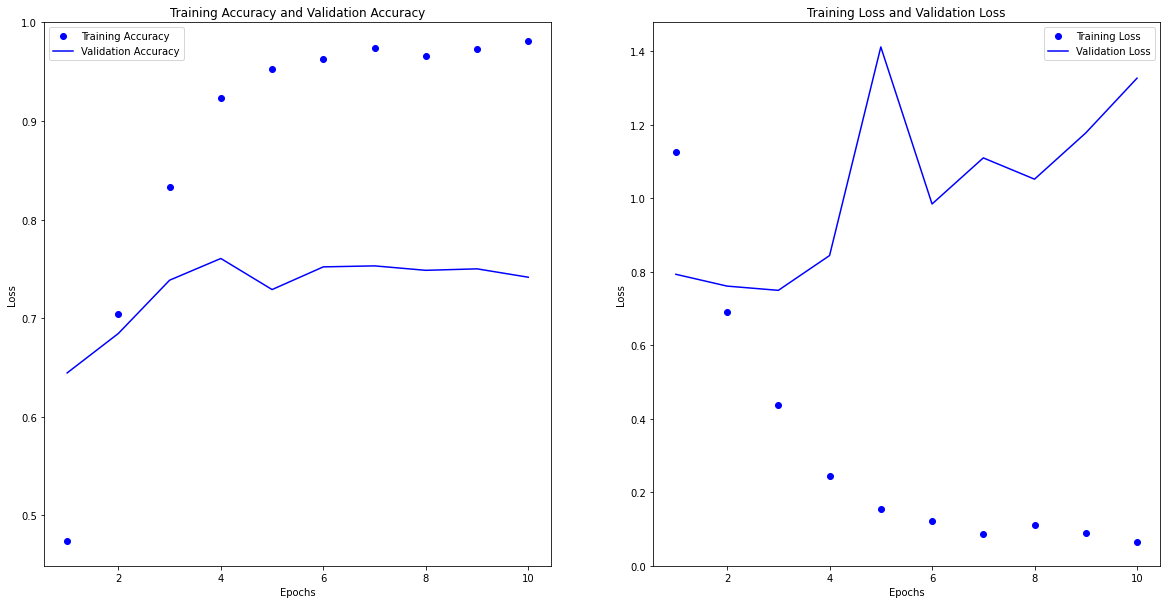

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 28s 83ms/step - loss: 0.7979 - accuracy: 0.7226
Test Loss: 0.797921895980835
Test Accuracy: 0.7226250171661377


In [44]:
# TODO Plot histories
plot_history(history.history)
# TODO Evaluate them
encoded_test = data_test.map(lambda x, y: (encoder(x), y))
test_loss, test_acc = model.evaluate(encoded_test)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

### Problem (7) Process new strings

a) Export the model to take raw strings as inputs (Hint: compile the TextVectorization layer and the model together to a new model). Take the following questions as input, what are the predicted tags?  Do you agree with the tags predicted by your model? (Code and text)
* "how do I extract keys from a dict into a list?"
* "debug public static void main(string[] args) {...}"
> The predicted tags are `python` and `java` respectively. They seem legit, since the first string contains Python keywords such as `dict` and `list`, and the second string contains code in Java syntaxes `public static void main(string[] args) {...}`.

In [45]:
trial1 = "how do I extract keys from a dict into a list?"
trial2 = "debug public static void main(string[] args) ..."

trials = [trial1, trial2]

for trial in trials:
    # TODO pass these text values through the model.
    x = encoder(tf.expand_dims(trial, 0))
    y = model.predict(x)
    # TODO print the predictions
    label = tf.argmax(y, axis=1)
    print(data_train.class_names[label[0]])

python
java


### Problem (8) Compare CNN with RNN
What is the conceptual difference between image classification and text classification in terms of feature extractions? (Think spatial vs temporal.)

* Image classification extracts edges as features. Convolution with feature selection mask is performed through the pixels to extract certain patterns/edge on the image). The feature are then preserved and passed onto the next neural network layer.

* Text Classification extract keywords as features.In order to classify some text data, texts are broken down into vocabularies, from which the classification model can pick certain keywords and then analyze from their contextual information.